## Black-box optimization with a generic GP agent

In this example, we will show how to setup a "textbook" black-box optimization problem of finding extrema of an unknown function, as a campaign within the CAMD framework, and solve the problem with an off-the-shelf Gaussian Process based agent with an upper-confidence-bound approach for exploration/exploitation tradeoff.

We will follow this outline:

1. Define a sample function to generate synthetic data
2. Define data, agent, experiment and analyzer of our campaign
3. Intiailize the campaign with a random seed
4. Run several iterations and keep track of the progress of the agent. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, shutil

from camd.agent.generic import GenericGPUCB
from camd.analysis import GenericMaxAnalyzer
from camd.experiment.base import ATFSampler
from camd.campaigns.base import Campaign

from sklearn.preprocessing import OrdinalEncoder
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, Matern
import warnings
warnings.filterwarnings("ignore")

def plot_state(x, y, campaign):
    """
    this is a helper function to make plots
    """
    mu, std  = campaign.agent.pipeline.predict(
        x.reshape(-1,1), return_std=True
    )
    plt.plot(x, mu, label='agent')
    plt.fill_between(x, mu+std, mu-std, alpha=0.2)
    plt.plot(campaign.seed_data['x'], campaign.seed_data['target'], 'ko',alpha=0.7, label='acquired')
    requests = campaign.experiment.dataframe.loc[campaign.consumed_candidates[-campaign.agent.n_query:]]
    plt.plot(requests['x'],requests['target'],'rx',alpha=0.9, label='requested')
    plt.plot(x, y, label='true f(x)')
    plt.legend()
    return plt

Let's generate some synthetic data using an arbitrary function, with one column for X and one target column.

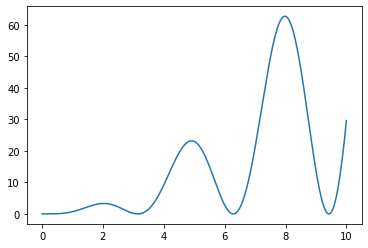

In [2]:
def f(x):
    return np.sin(x)*np.sin(1*x)*(x**2)
x = np.linspace(0,10,500)
y = f(x)
df = pd.DataFrame({'x': x, 'target': y})
plt.plot(x,y)

Now, say we want to maximize this "unknown" function. We will use a generic GP-UCB agent and a generic analyzer of campaigns for acquiring 'maxima' from a candidate set. Say we also want to know number of points with target value above 58.

In [3]:
N_query = 2  # This many experiments are requested in each iteration
N_seed = 5  # This many samples are randomly acquired in the beginning to form a seed.

agent = GenericGPUCB(
    n_query=N_query,
    kernel=ConstantKernel(100.)*RBF(10.)*ConstantKernel(1.0)
)
analyzer = GenericMaxAnalyzer(threshold=58)
experiment = ATFSampler(dataframe=df)
candidate_data = df

Now we setup a campaign and initialize it. Here we instructed the Loop to generate a seed with 5 randomly selected points.

In [4]:
path = os.path.join(os.getcwd(), "generic_gp_ucb")
shutil.rmtree(path, ignore_errors=True)
os.makedirs(path)
new_campaign = Campaign(
    candidate_data, agent, experiment, analyzer, 
    create_seed=N_seed, path=path)
new_campaign.initialize(random_state=6)

Campaign initialization state: Agent RandomAgent hypothesizing
Campaign 0 state: Running experiments


Let's have our agent acquire two new points and plot our results.

Campaign 0 state: Getting new results
Campaign 0 state: Analyzing results
Campaign 0 state: Agent GenericGPUCB hypothesizing
Campaign 0 state: Running experiments


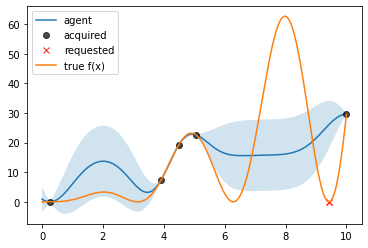

In [5]:
new_campaign.run()
plt = plot_state(x, y, new_campaign)
plt.show()

We see that the GP-UCB agent requested two new points where it thought there would be a maximum, but its prediction was pretty far off there. Let's run another iteration.

Campaign 1 state: Getting new results
Campaign 1 state: Analyzing results
Campaign 1 state: Agent GenericGPUCB hypothesizing
Campaign 1 state: Running experiments


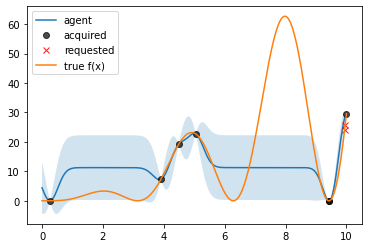

In [6]:
new_campaign.run()
plt = plot_state(x, y, new_campaign)
plt.show()

Now it knows it's previous acquisition was low, so it's able to make a more intelligent choice, but still hasn't yet explored the region where the max is.

Campaign 2 state: Getting new results
Campaign 2 state: Analyzing results
Campaign 2 state: Agent GenericGPUCB hypothesizing
Campaign 2 state: Running experiments


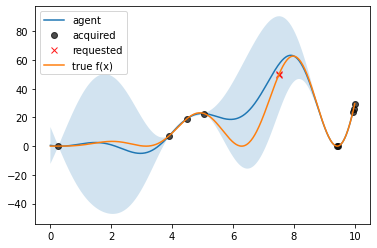

In [7]:
new_campaign.run()
plt = plot_state(x,y,new_campaign)
plt.show()

Now it's more or less converged on the right-most region, and correctly identifies the potential of the intermediate region.

Campaign 3 state: Getting new results
Campaign 3 state: Analyzing results
Campaign 3 state: Agent GenericGPUCB hypothesizing
Campaign 3 state: Running experiments


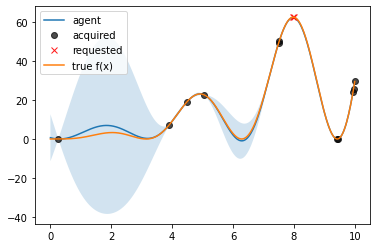

In [8]:
new_campaign.run()
plt = plot_state(x,y,new_campaign)
plt.show()

At this point, the agent's able to make a very optimal choice.

**Conclusion**: In the context of materials science experiments, for many "low-throughput" campaigns (e.g. up to a few thousand examples) and/or low-dimensional search spaces (e.g. up to ten or twenty parameters to control), this approach is often worth trying.